In [66]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_classic import hub 
from langchain_core.messages import BaseMessage, HumanMessage 
from langchain_core.output_parsers import StrOutputParser 
from langchain_core.prompts import PromptTemplate 
from pydantic import BaseModel, Field
from langgraph.graph.message import add_messages 
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_community.document_loaders import WebBaseLoader 
from langchain_community.vectorstores import Chroma 
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter 
from langchain_classic.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START 
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
import PyPDF2 as pdf
from langchain_classic.schema import Document
from langchain_classic.tools import Tool
from langchain_classic.tools import tool

In [68]:
from dotenv import load_dotenv
load_dotenv()

True

In [120]:
embeddings = HuggingFaceEmbeddings(model_name = "HooshvareLab/bert-fa-base-uncased")

No sentence-transformers model found with name HooshvareLab/bert-fa-base-uncased. Creating a new one with mean pooling.


In [121]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [122]:
def data_preparation(pdf_path):
    with open(pdf_path, "rb") as file:
        reader = pdf.PdfReader(file)
        text = "" 
        for page in reader.pages:
            extracted = page.extract_text()
            if extracted:
                text += extracted 
    
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size = 1500,
        chunk_overlap = 100
    )
    chunks = splitter.split_text(text)
    docs = [Document(page_content = chunk) for chunk in chunks]
    return docs

In [123]:
documents = data_preparation("C:\\Users\\Lenovo\\Desktop\\datapdf\\rooze.pdf")

In [124]:
documents[:3]

[Document(metadata={}, page_content='۱ .معنای روز ه  \n«    در شرع مقدس اسالم آن است که انسان در تمام روز (از طلوع فجر تا غروب آفتاب) با قصد اطاعت»روزه\nاز فرمان خداوند از خوردن و آشامیدن و چیزهای دیگری که به تفصیل گفته خواهد شد خودداری کند . \nتوجه: \n معیار شرعی در مورد وقت روزه، فجر صادق است نه کاذب، و احراز آن موکول به تشخیص مکلف است. \n در طلوع فجر (وقت وجوب امساک برای روزه گرفتن) فرقی بین شبهای مهتابی و غیر مهتابی نیست . \n  جهت رعایت احتیاط در امساک روزه، همزمان با  »اَیَّدَهُمُ اهللُ تَعَالی« مقتضی است که مؤمنین محترم\nشروع اذان صبح از رسانه ها برای روزه امساک نمایند . \n هرگاه برای روزه دار اطمینان حاصل شود که اذان از هنگام داخل شدن وقت شروع شده جایز است به  \nصرف شروع اذان، افطار نماید و صبر کردن تا پایان اذان الزم نیست. \n \n ۲ .انواع روز ه  \nروزه از یک نظر بر چهار نوع است: \n۱ .روزه ی واجب، مثل روز ه ی ماه مبارک رمضان. \n۲ .روزه ی مستحب، مثل روزهی ماه رجب و شعبان . \n۳ .روز ه ی مکروه، مثل روزه ی روز عاشورا. \n۴ .روز ه ی حرام مثل روزه ی عید فطر(اول ماه شوال) و قربان(دهم ماه

In [125]:
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    collection_name="fa2_bert_768", 
    persist_directory="chroma_fa2_bert_768"  
)

In [126]:
retriever = vectorstore.as_retriever(k = 3)

In [127]:
retriever.invoke("چه مواردی روزه را باطل می کند؟")

[Document(metadata={}, page_content='روزه باطل می شود. (بر استفاده از قرص جهت درمان، عنوان خوردن صدق می کند). \n۰۱ .خونی که از لثه بیرون می آید تا آن را فرو نبرده است روزه باطل نمی شود و چنانچه در آب دهان  \nمستهلک شود (و از بین برود) محکوم به طهارت است و بلعیدن آن اشکال ندارد و مبطل روزه نخواهد بود، و  \nهمچنین در صورت شک در همراه بودن آب دهان با خون، فرو بردن آن اشکال ندارد و به صحت روزه ضرر  \nنخواهد زد. \n توجه: \n به صرف بیرون آمدن خون از دهان، روزه باطل نمی شود، ولی واجب است از رسیدن آن به حلق جلوگیری   \nکند . \n \nجماع (آمیزش جنسی)  \n۱ .آمیزش جنسی روزه را باطل می  کند، هر چند منی بیرون نیاید . \n۲ .اگر فراموش کند که روزه است و آمیزش جنسی کند، روزه  ی او باطل نمی شود، ولی هر لحظه که یادش  \nآمد باید فوراً از حال آمیزش خارج شود وگرنه روزه اش باطل است. \n \nاستمنا (خود ارضایی جنسی ) \n۱ .اگر روزه  دار عمداً کاری کند که منی از او بیرون بیاید روزه اش باطل می شود. \n۲ .محتلم شدن در روز (خروج منی در حال خواب) روزه را باطل نمی  کند، و هرگاه روزهدار بداند که اگر در   \nروز بخوابد محتلم

In [128]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [129]:
class grade(BaseModel):
    binary_score: str = Field(description = "Relevance score 'yes' or 'no'")

In [175]:
def retrieve_ahkam(query: str):
    """retrive docs"""
    docs = retriever.invoke(query)
    return "\n\n".join([d.page_content for d in docs])

In [176]:
tools = [retrieve_ahkam]

In [177]:
retrieve = ToolNode(tools)

In [178]:
def ai_assistant(state: AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    llm_with_tool = llm.bind_tools(tools)
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [179]:
def grade_documents(state: AgentState):
    llm_with_structure_op = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template = """تو یک نمره دهنده هستی که تصمیم می گیرد یک سند مربوط به سوال کاربر است یا خیر.
        سند: {context}
        سوال کاربر: {question}
        اگر سند حاوی اطلاعاتی مربوط به سوال کاربر است، آن را به عنوان یک سند مربوط نشانه گذاری کن.
        برای آنکه نشان دهی سند به سوال مربوط است یا خیر، یک جواب 'yes' یا 'no' بده.""",
        input_variables = ["context", "question"])

    chain = prompt | llm_with_structure_op

    messages = state["messages"]
    print(f"message from the grader: {messages}")
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter"


In [184]:
def generate(state: AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    last_message = messages[-1]
    docs = last_message.content

    prompt = PromptTemplate(
        template = """فقط بر اساس متن ارائه شده، به سوال پاسخ بده.  
        متن: {context}
        سوال: {question}
""",
        input_variables = ["context", "question"]
    )

    rag_chain = prompt | llm 

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response: {response}")

    return {"messages": [response]}

In [185]:
def rewrite(state: AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    message = [HumanMessage(content = f"""به سوال دقت کن و در مورد قصد یا مفهوم معنایی نهفته در آن استدلال کن.
این سوال اولیه است: {question}
روی سوال بهبود یافته فرموله کن: """)]
    response = llm.invoke(message)
    return {"messages": [response]}

In [186]:
workflow = StateGraph(AgentState)
workflow.add_node("My_Ai_Assistant", ai_assistant)
workflow.add_node("Vector_Retriever", retrieve)
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite)

workflow.add_edge(START, "My_Ai_Assistant")
workflow.add_conditional_edges("My_Ai_Assistant", 
                               tools_condition,
                               {"tools": "Vector_Retriever",
                                END: END})

workflow.add_conditional_edges("Vector_Retriever",
                               grade_documents,
                               {"generator": "Output_Generator",
                                "rewriter": "Query_Rewriter"})

workflow.add_edge("Output_Generator", END)
workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")

app = workflow.compile()

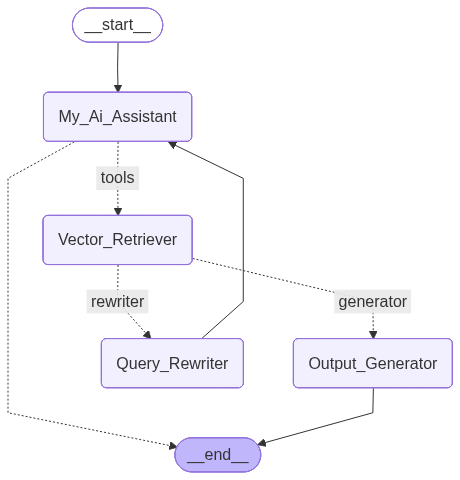

In [154]:
app

In [187]:
result2 = app.invoke({"messages": "روزه بر چه کسانی واجب است؟"})

---CALL AGENT---
message from the grader: [HumanMessage(content='روزه بر چه کسانی واجب است؟', additional_kwargs={}, response_metadata={}, id='ae0997c9-22d1-4b27-92fa-64d3647fdeef'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9z093xwqc', 'function': {'arguments': '{"query":"روزه بر چه کسانی واجب است"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 223, 'total_tokens': 248, 'completion_time': 0.058894615, 'prompt_time': 0.0147726, 'queue_time': 0.04316251, 'total_time': 0.073667215}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--91b98e63-f980-4e6c-967e-d5142ef377c7-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'روزه بر چه کسانی واجب است'}, 'id': '9z093xwqc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'outpu

In [188]:
result2

{'messages': [HumanMessage(content='روزه بر چه کسانی واجب است؟', additional_kwargs={}, response_metadata={}, id='ae0997c9-22d1-4b27-92fa-64d3647fdeef'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '9z093xwqc', 'function': {'arguments': '{"query":"روزه بر چه کسانی واجب است"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 223, 'total_tokens': 248, 'completion_time': 0.058894615, 'prompt_time': 0.0147726, 'queue_time': 0.04316251, 'total_time': 0.073667215}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--91b98e63-f980-4e6c-967e-d5142ef377c7-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'روزه بر چه کسانی واجب است'}, 'id': '9z093xwqc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'output_tokens': 25, 'total_token

In [189]:
print(result2["messages"][-1].content)

روزه بر افرادی واجب است که واجد شرایط زیر باشند: 
بلوغ 
عقل 
قدرت 
بی هوش نبودن 
مسافر نبودن 
حایض و نفسا نبودن 
ضرری نبودن 
حرجی نبودن


In [190]:
result3 = app.invoke({"messages": "چه چیزهایی روزه را باطل می کند؟"})

---CALL AGENT---
message from the grader: [HumanMessage(content='چه چیزهایی روزه را باطل می کند؟', additional_kwargs={}, response_metadata={}, id='45ee8f9d-a218-43b8-a8d9-4d5e6dccdebb'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kxgh81nmp', 'function': {'arguments': '{"query":"things that invalidate fasting"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 225, 'total_tokens': 246, 'completion_time': 0.058697588, 'prompt_time': 0.010827412, 'queue_time': 0.041970471, 'total_time': 0.069525}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--00ed09bc-25b4-45a2-9018-f7df21808b75-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'things that invalidate fasting'}, 'id': 'kxgh81nmp', 'type': 'tool_call'}], usage_metadata={'input_token

In [191]:
result3

{'messages': [HumanMessage(content='چه چیزهایی روزه را باطل می کند؟', additional_kwargs={}, response_metadata={}, id='45ee8f9d-a218-43b8-a8d9-4d5e6dccdebb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kxgh81nmp', 'function': {'arguments': '{"query":"things that invalidate fasting"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 225, 'total_tokens': 246, 'completion_time': 0.058697588, 'prompt_time': 0.010827412, 'queue_time': 0.041970471, 'total_time': 0.069525}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--00ed09bc-25b4-45a2-9018-f7df21808b75-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'things that invalidate fasting'}, 'id': 'kxgh81nmp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 225, 'output_tokens': 2

In [192]:
print(result3["messages"][-1].content)

روزه باطل می شود به شرطی که روزه دار عمداً و آگاهانه کاری را انجام دهد که از نظر شرعی روزه را باطل کند. از جمله کارهایی که روزه را باطل می‌کنند، می‌توان به خوراکی‌ها و آشامیدنی‌ها، جماع (آمیزش جنسی)، استمنا (خود ارضایی جنسی)، دروغ بستن به خدا و پیامبران و معصومین، رساندن غبار غلیظ به حلق، فرو بردن تمام سر در آب، باقی ماندن بر جنابت و حیض و نفاس تا اذان صبح، اماله (تنقیه) کردن با مایعات، و قی کردن عمدی اشاره کرد.


In [193]:
result4 = app.invoke({"messages": "هوش مصنوعی چیست؟"})

---CALL AGENT---
message from the grader: [HumanMessage(content='هوش مصنوعی چیست؟', additional_kwargs={}, response_metadata={}, id='224934f3-38e2-4258-89d0-35985e21a331'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'p0962w101', 'function': {'arguments': '{"query":"هوش مصنوعی چیست"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 221, 'total_tokens': 244, 'completion_time': 0.045369145, 'prompt_time': 0.010724363, 'queue_time': 0.041599895, 'total_time': 0.056093508}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--de0249b5-f094-4ab1-ab10-6d3e5687ed20-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'هوش مصنوعی چیست'}, 'id': 'p0962w101', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 23, 'total_token

In [194]:
result4

{'messages': [HumanMessage(content='هوش مصنوعی چیست؟', additional_kwargs={}, response_metadata={}, id='224934f3-38e2-4258-89d0-35985e21a331'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'p0962w101', 'function': {'arguments': '{"query":"هوش مصنوعی چیست"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 221, 'total_tokens': 244, 'completion_time': 0.045369145, 'prompt_time': 0.010724363, 'queue_time': 0.041599895, 'total_time': 0.056093508}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--de0249b5-f094-4ab1-ab10-6d3e5687ed20-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'هوش مصنوعی چیست'}, 'id': 'p0962w101', 'type': 'tool_call'}], usage_metadata={'input_tokens': 221, 'output_tokens': 23, 'total_tokens': 244}),
  ToolMessage(co

In [197]:
print(result4["messages"][-1].content)

  هوش مصنوعی (AI) به عنوان یک زمینه از علوم کامپیوتر، به توسعه سیستم‌ها و ماشین‌هایی اشاره دارد که می‌توانند وظایف و کارهای خاصی را به طور خودکار و با استفاده از الگوریتم‌ها و داده‌ها انجام دهند. این فناوری در حال حاضر در بسیاری از جنبه‌های زندگی ما از جمله خودروهای خودران، تشخیص تصویر، سیستم‌های 推荐، و بسیاری از زمینه‌های دیگر کاربرد دارد.  اگر می‌خواهید بیشتر در مورد هوش مصنوعی بدانید، می‌توانید به منابع مختلفی از جمله کتاب‌ها، مقالات، و وب‌سایت‌ها مراجعه کنید. همچنین می‌توانید به طور مستقیم از طریق جستجوی اینترنتی به اطلاعات مربوط به هوش مصنوعی دسترسی پیدا کنید.


In [198]:
result5 = app.invoke({"messages": "پایتخت ایران کدام شهر است؟"})

---CALL AGENT---
message from the grader: [HumanMessage(content='پایتخت ایران کدام شهر است؟', additional_kwargs={}, response_metadata={}, id='3eefadc5-947a-43d4-8cae-f2d9d9fa02b5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v89c0jr4n', 'function': {'arguments': '{"query":"پایتخت ایران"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 223, 'total_tokens': 244, 'completion_time': 0.038671826, 'prompt_time': 0.010833868, 'queue_time': 0.041637582, 'total_time': 0.049505694}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--42d1f44d-ffc7-4c29-af1d-7690e590bba1-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'پایتخت ایران'}, 'id': 'v89c0jr4n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'output_tokens': 21, 'total_t

In [199]:
result5

{'messages': [HumanMessage(content='پایتخت ایران کدام شهر است؟', additional_kwargs={}, response_metadata={}, id='3eefadc5-947a-43d4-8cae-f2d9d9fa02b5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'v89c0jr4n', 'function': {'arguments': '{"query":"پایتخت ایران"}', 'name': 'retrieve_ahkam'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 223, 'total_tokens': 244, 'completion_time': 0.038671826, 'prompt_time': 0.010833868, 'queue_time': 0.041637582, 'total_time': 0.049505694}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_f8b414701e', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--42d1f44d-ffc7-4c29-af1d-7690e590bba1-0', tool_calls=[{'name': 'retrieve_ahkam', 'args': {'query': 'پایتخت ایران'}, 'id': 'v89c0jr4n', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'output_tokens': 21, 'total_tokens': 244}),
  ToolMessag

In [200]:
print(result5["messages"][-1].content)

 

پاسخ به سوال اول: 
پایتخت فعلی ایران، تهران است.

پاسخ به سوال دوم: 
پایتخت های مختلفی در طول تاریخ ایران وجود داشته اند. در دوره های مختلف، شهرهای مانند تیسفون، همدان، شوش، اصفهان و دیگر شهرهای مهم به عنوان پایتخت عمل کرده اند. اما پایتخت فعلی ایران، تهران است. تهران از سال ۱۲۱۲ خورشیدی (۱۷۹۸ میلادی) به عنوان پایتخت ایران شناخته شده است.


In [204]:
print(result5["messages"][0].content)

پایتخت ایران کدام شهر است؟


In [205]:
print(result5["messages"][1].content)

In [206]:
print(result5["messages"][2].content)

آن که اطمینان به ثبوت هالل حاصل نمایند . 
توجه : 
 اگر شخصی هالل ماه را ببیند و بداند که رؤیت هالل برای حاکم شرع شهر او به هر علتی ممکن نیست،  
واجب نیست رؤیت هالل را به حاکم اطالع دهد مگر آن که ترک آن مفسده داشته باشد . 
 اگر حاکم حکم نماید که فردا عید است و این حکم، شامل همه ی کشور باشد حکم او شرعاً برای همه ی  
شهرها معتبر است. 
 در تبعیت از اعالم رؤیت هالل توسط یک حکومت، اسالمی بودن آن حکومت شرط نیست، بلکه مالک در   
این مورد، حصول اطمینان به رؤیت در منطقه یی است که نسبت به مکلف کافی محسوب می شود. 
 اگر هالل ماه در شهری دیده نشود ولی تلویزیون و رادیو از حلول آن خبر دهند، در صورتی که مفید  
اطمینان به ثبوت هالل گردد یا صدور حکم به هالل از طرف ولی فقیه باشد کافی است و نیازی به تحقیق  
نیست. 
 
۴ .اگر اول ماه از طریق رؤیت هالل حتی در افق شهرهای مجاوری که یک اف ق دارند و یا از طریق شهادت  
دو فرد عادل و یا از طریق حکم حاکم ثابت نشود باید احتیاط کرد تا اول ماه ثابت شود . 
۵ .اگر اول ماه رمضان ثابت نشود روزه واجب نیست، ولی اگر بعداً ثابت شود که آن روزی را که روزه نگرفته   
اول ماه بوده ب

In [207]:
print(result5["messages"][3].content)

پایتخت ایران کدام شهر است؟ این سوال می تواند بهبود یافته شود تا مشخص شود که آیا پرسشگر به دنبال نام شهر پایتخت ایران در حال حاضر است یا می خواهد تاریخچه پایتخت های ایران را بداند.

سوال بهبود یافته: 
"پایتخت فعلی ایران کدام شهر است؟" یا 
"شهرهای مختلفی در طول تاریخ به عنوان پایتخت ایران عمل کرده اند، ولی پایتخت فعلی ایران کدام شهر است؟"


In [208]:
print(result5["messages"][4].content)

 

پاسخ به سوال اول: 
پایتخت فعلی ایران، تهران است.

پاسخ به سوال دوم: 
پایتخت های مختلفی در طول تاریخ ایران وجود داشته اند. در دوره های مختلف، شهرهای مانند تیسفون، همدان، شوش، اصفهان و دیگر شهرهای مهم به عنوان پایتخت عمل کرده اند. اما پایتخت فعلی ایران، تهران است. تهران از سال ۱۲۱۲ خورشیدی (۱۷۹۸ میلادی) به عنوان پایتخت ایران شناخته شده است.
